In [1]:
# Built-in
from pathlib import Path

# Third-party
from matplotlib import pyplot as plt
from matplotlib import style, cm
from scipy.stats import gmean, fisher_exact, ttest_1samp
import seaborn as sns
import pandas as pd
import numpy as np
import feather

work = "jp2"

In [2]:
samples = {
    'jp2': ['siNC', 'siLARP1-3', 'siLARP1-S', 'siLARP44B', 'siMKRN1', 'siMKRN1siLARP1-3'],
}[work]

subsamples = ['siNC', 'siLARP1-3', 'siLARP44B']

ctrl = {
}.get(work, samples[0])

#### Load gene-level statistics

In [3]:
glstatsPath = "/utp/joha/projects/jp/works/{}/stats/genelevelstats-GRCh38-single.csv".format(work)
df_glstats = pd.read_csv(glstatsPath, index_col=0)
print( len(df_glstats) )

# Handle AttuributeError if any
df_glstats = df_glstats.dropna(subset=["gene_description"])
print( len(df_glstats) )

16951
16951


In [4]:
genepath = "/casa/joha/scripts/tailseeker3.1.7/refdb/level3/GRCh38/annotations-gene.feather"
df_gene = feather.read_dataframe(genepath)

# Mitochondrially-encoded genes
df_mtgenes = df_gene[df_gene["seqname"].map(lambda x: x == "chrM" if x else False)]
mtgenes = df_mtgenes["gene_id"]
mtgenes = mtgenes.append(pd.Series(['ENSG00000247627.2', 'ENSG00000248527.1']) ) # adding MTND4P12, MTATP6P1 pseudogenes
print( len(mtgenes), "MT-encoded genes")

# TOP genes: The list is from Yamashita et al., NAR, 2008
topglist = [g.strip().upper() for g in open("../data/external/human_top_genes_nar_2008.csv", "rt").readlines()]
df_topgenes = df_gene[df_gene["gene_name"].isin(topglist)]
topgenes = df_topgenes["gene_id"]
print( len(topgenes), "TOP genes" )

# RP genes
df_rpgenes = df_gene[df_gene["gene_description"].map(lambda x: x.startswith("ribosomal protein") if x else False)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "kinase" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "like" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "binding" not in x)]
print(len(df_rpgenes), "RP genes")
rpgenes = df_rpgenes["gene_id"]

gene_subsets = {
    'mtgenes': mtgenes,
    'topgenes': topgenes,
    'rpgenes': rpgenes,
}

subset_labels = {
    'mtgenes': 'mt-mRNA',
    'topgenes': 'TOP mRNA',
    'rpgenes': 'RP mRNA',
}

39 MT-encoded genes
89 TOP genes
1177 RP genes


/utp/joha/miniconda3/envs/polya/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


['siNC', 'siLARP1-3', 'siLARP44B']

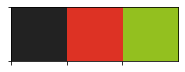

In [5]:
# colors by sample
colors = { 
    'mock': '#000000',
    'siNC': '#222222',
    'Input': '#222222',
    
    'LARP1': '#DD3224',
    'siLARP1': '#DD3224',
    'siLARP1-3': '#DD3224',
    'siLARP1-S': '#FF0524',
    
    'LARP4': '#F4D348',
    'LARP5': '#93C01F',
    'siLARP4_5': '#93C01F',
    'siLARP44B': '#93C01F',
    
    'sieIF4G': '#071AF5',
    'eIF4G1': '#071AF5',
    
    'siMKRN': '#F4D348',
    'siMKRN1': '#F4D348',
    'siMKRN1siLARP1-3': '#0750A5',
    'PABP': '#0750A5',
    
    'mtgenes': '#FF8B00',
    'topgenes': '#273AE2',
}

sns.palplot([colors[smp] for smp in subsamples])
subsamples

### Normalized by the geometric mean of mtRNA readcounts

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found

/casa/joha/projects/polya/plots/ma_plot_jp2_mt-normed_siLARP1-3_mini.pdf saved


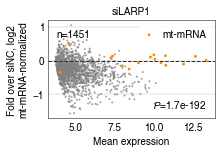

/casa/joha/projects/polya/plots/ma_plot_jp2_mt-normed_siLARP44B_mini.pdf saved


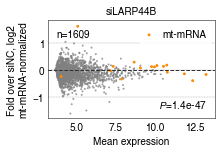

In [6]:
# Configurations
savefig = True
minifig = True
ttest=True

figsize = 6, 3.6
subsets = ["mtgenes"]
mtgenes_cutoff = 500
scaler = 1000
normed_tagcnt_cutoff = 12.5

styles = ['barricade']
if minifig is True:
    styles.append('mini')
    figsize = list(map(lambda x:x/2, figsize))

def get_mtnormed_tagcnts(smp, df):
    global mtgenes, mtgenes_cutoff, scaler, normed_tagcnt_cutoff
    tagcnts = df[[f"{smp}:polyA_tag_count", f"{smp}:nonpolyA_tag_count"]].sum(axis=1).dropna()
    mtgenes_tagcnts = tagcnts[mtgenes]
    mtgenes_tagcnts = mtgenes_tagcnts[mtgenes_tagcnts >= mtgenes_cutoff]
    normed = tagcnts / gmean(mtgenes_tagcnts) * scaler
    
    return normed[normed >= normed_tagcnt_cutoff]
    
tagcnts_ctrl = get_mtnormed_tagcnts(ctrl, df_glstats)

with plt.style.context(styles):
    for smp in subsamples:
        if smp == ctrl: continue
        fig, ax = plt.subplots(figsize=figsize)
        
        tagcnts = get_mtnormed_tagcnts(smp, df_glstats)
        
        x, y = tagcnts_ctrl.align(tagcnts, join="inner")
        
        M = np.log2(y) - np.log2(x)
        A = np.log2(x*y) / 2       
        
        ax.scatter(A, M, s=4, color='gray', edgecolor="none", alpha=0.75, rasterized=True)
        
        for subset in subsets:
            subset_genes = gene_subsets[subset]
            ax.scatter(A[subset_genes], M[subset_genes], s=8, color=colors[subset], edgecolor='none', rasterized=True, label=subset_labels[subset])
        
        if ttest:
            pval = ttest_1samp(M, 0).pvalue / 2
            if pval < 0.01:
                ax.text(0.95, 0.1, "$\mathit{P}$=%.1e"%(pval), transform=ax.transAxes, color='k', ha="right")
            else:
                ax.text(0.95, 0.1, "$\mathit{P}$=%.2f"%(pval), transform=ax.transAxes, color='k', ha="right")

            
        
        ax.axhline(y=0, ls="--", lw=1)
        ax.grid(axis="y")
#         ax.set_xlim([3, 15])
#         ax.set_ylim([-2.8, 1.2])
        ax.set_xlabel("Mean expression")
        ax.set_ylabel(f"Fold over {ctrl}, log2\nmt-mRNA-normalized")
        ax.set_title("{}".format(smp.split('-')[0]), fontsize="medium")
        ax.legend(loc="upper right")
        
        ax.text(0.05, 0.83, "n={}".format(len(M)), transform=ax.transAxes, ha="left")
        
        fname_adduct = ""
        if minifig: fname_adduct += "_mini"

        if savefig is True:
            outfigpath = "/casa/joha/projects/polya/plots/ma_plot_{}_mt-normed_{}{}.pdf".format(work, smp, fname_adduct)
            plt.savefig(outfigpath, bbox_inches='tight', dpi=300)
            print(outfigpath, 'saved')
            
        plt.show()



### RPM normalization and a statistical test for the TOP gene preference

((15, 1), (681, 733))
16.145374449339208 0.00018686669858819984
((1, 55), (681, 733))
0.019570150847683886 1.7592945237528177e-14
/casa/joha/projects/polya/plots/ma_plot_jp2_rpm-normed_siLARP1-3_mini.pdf saved


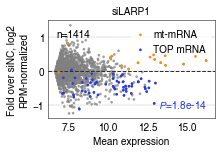

((11, 5), (704, 711))
2.221875 0.1410836316976358
((24, 33), (704, 711))
0.734504132231405 0.28139625522544565
/casa/joha/projects/polya/plots/ma_plot_jp2_rpm-normed_siLARP44B_mini.pdf saved


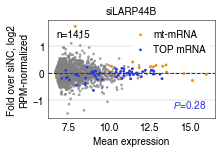

In [16]:
savefig = True

figsize = 6, 3.6
fishertest = True
subsets = ["mtgenes", "topgenes"]
mtgenes_cutoff = 0
scaler = 1000
normed_tagcnt_cutoff = 100

styles = ['barricade']
if minifig is True:
    styles.append('mini')
    figsize = list(map(lambda x:x/2, figsize))

ctrl_tagcnts = df_glstats[["{}:polyA_tag_count".format(ctrl), "{}:nonpolyA_tag_count".format(ctrl)]].sum(axis=1).dropna()
ctrl_normed = ctrl_tagcnts / (ctrl_tagcnts.sum() / 1000000)
ctrl_normed = ctrl_normed[ctrl_normed >= normed_tagcnt_cutoff]
with plt.style.context(styles):
    for smp in subsamples:
        if smp == ctrl: continue
        fig, ax = plt.subplots(figsize=figsize)
        
        tagcnts = df_glstats[["{}:polyA_tag_count".format(smp), "{}:nonpolyA_tag_count".format(smp)]].sum(axis=1).dropna()
        normed = tagcnts / (tagcnts.sum() / 1000000)

        # Normed minimum tag count filter
        
        normed = normed[normed >= normed_tagcnt_cutoff]
        
        x, y = ctrl_normed.align(normed, join="inner")

        M = np.log2(y) - np.log2(x)
        A = np.log2(x*y) / 2

        ax.scatter(A, M, s=7, color="grey", edgecolor="none", alpha=0.75, rasterized=True)
        
        # Fischer's exact test for enrichment or depletion of the subset
        if fishertest is True:
            fisher_res = dict()
            for subset in subsets:
                subset_genes = gene_subsets[subset]
                tbl = ( (M.reindex(subset_genes) > 0).sum(),(M.reindex(subset_genes) <= 0).sum() ), \
                      ( (M > 0).sum(), (M <= 0).sum() )
                odds, pval = fisher_exact(tbl)
                print( tbl )
                print(odds, pval)
                fisher_res[subset] = (odds, pval)
                
        # Marking subsets
        for subset in subsets:
            subset_genes = gene_subsets[subset]
            ax.scatter(A.reindex(subset_genes), M.reindex(subset_genes), s=7, color=colors[subset], edgecolor="none", label=subset_labels[subset], zorder=7)
            
        ax.axhline(y=0, ls="--", lw=1)
        ax.grid(axis='y')
        ax.set_xlabel("Mean expression")
        ax.set_ylabel(f"Fold over {ctrl}, log2\nRPM-normalized")
        ax.set_title(smp.split('-')[0], fontsize='medium')
        ax.legend(loc="upper right")
        
        ax.text(0.05, 0.83, "n={}".format(len(M)), transform=ax.transAxes, ha="left")
        
        if fishertest is True:
            for mi, subset in enumerate(subsets):
                if subset == "mtgenes": continue
                odds, pval = fisher_res[subset]
                if pval < 0.01:
                    ax.text(0.95, 0.1, "$\mathit{P}$=%.1e"%(pval), transform=ax.transAxes, color=colors[subset], ha="right")
                else:
                    ax.text(0.95, 0.1, "$\mathit{P}$=%.2f"%(pval), transform=ax.transAxes, color=colors[subset], ha="right")
                    
        fname_adduct = ""
        if minifig: fname_adduct += "_mini"
        
        if savefig is True:
            outfigpath = "/casa/joha/projects/polya/plots/ma_plot_{}_rpm-normed_{}{}.pdf".format(work, smp, fname_adduct)
            plt.savefig(outfigpath, bbox_inches="tight", dpi=300)
            print(outfigpath, 'saved')
            
        plt.show()


#### Normalisation by mtRNA readcounts and NC ratio colouring

In [9]:
import os

nc_samples = ["cyt-1", "cyt-2", "nuc-1", "nuc-2"]
groups = ["cyt", "cyt", "nuc", "nuc"]
desired_columns = ["index", "gene_name", ""]
quantDir = "/utp/joha/projects/deadenylases/external/encode_gingeras/rsem/quants/"

for si, s in enumerate(nc_samples):
    df = pd.read_table(os.path.join(quantDir, "{}.genes.results".format(s)), index_col=0).iloc[:,:-1]
    df = df.rename(columns = {'TPM':s})
    df = df[["transcript_id(s)", s]]

    if si is 0: df_ncquant = df
    else: df_ncquant = df_ncquant.join(df[s])

In [10]:
### Merging replicates
def reduce_items(l):
    return sorted(list(set(l)), key=lambda i:l.index(i))

minimum_tpm = 10

replicates = reduce_items(groups)
df_tpm = df_ncquant.loc[:,nc_samples]
df_tpm.columns = pd.MultiIndex.from_tuples(list(zip(groups, nc_samples)))
df_exp = df_tpm.groupby(level=0 , axis=1).agg(np.mean)
df_exp = df_exp[(df_exp >= minimum_tpm).sum(axis=1) == len(replicates)]
log2cn = np.log2(df_exp["cyt"] / df_exp["nuc"])

/utp/joha/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


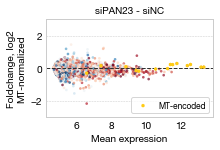

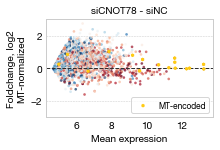

In [42]:
# Normalised by mtRNA readcounts and NC ratio colouring


from scipy.stats import gmean

savefig = True
savetxt = False

marks = ["mtgenes"]
mtgenes_cutoff = 100
scaler = 1000
normed_tagcnt_cutoff = 25

with plt.style.context("deadenylases"):
    for p in pairs:
        fig = plt.figure(figsize=[3,1.8])
        ax = fig.add_subplot(111)
        
        ctrl_tagcnts = df_glstats[["{}:polyA_tag_count".format(p[0]), "{}:nonpolyA_tag_count".format(p[0])]].sum(axis=1).dropna()
        tret_tagcnts = df_glstats[["{}:polyA_tag_count".format(p[1]), "{}:nonpolyA_tag_count".format(p[1])]].sum(axis=1).dropna()

        ctrl_mtgenes = ctrl_tagcnts[mtgenes]
        tret_mtgenes = tret_tagcnts[mtgenes]
        ctrl_mtgenes = ctrl_mtgenes[ctrl_mtgenes >= mtgenes_cutoff]
        tret_mtgenes = tret_mtgenes[tret_mtgenes >= mtgenes_cutoff]
        
        # Normalisation by mtRNA reads
        ctrl_tagcnts = ctrl_tagcnts / gmean(ctrl_mtgenes) * scaler
        tret_tagcnts = tret_tagcnts / gmean(tret_mtgenes) * scaler
        
        # Normalised tag count filter
        ctrl_tagcnts = ctrl_tagcnts[ctrl_tagcnts >= normed_tagcnt_cutoff]
        tret_tagcnts = tret_tagcnts[tret_tagcnts >= normed_tagcnt_cutoff]
        
        
        # RPM normalisation
#         ctrl_rpm = ctrl_tagcnts.div(ctrl_tagcnts.sum()) * 1000000
#         ctrl_rpm = ctrl_rpm[ctrl_rpm >= rpm_cutoff]
#         tret_rpm = tret_tagcnts.div(tret_tagcnts.sum()) * 1000000
#         tret_rpm = tret_rpm[tret_rpm >= rpm_cutoff]

        x, y = ctrl_tagcnts.align(tret_tagcnts, join="inner")
#         x, y = ctrl_rpm.align(tret_rpm, join="inner")


        M = np.log2(y) - np.log2(x)
        A = np.log2(x*y) / 2
        
        if savetxt is True:
            outTxtPath = "/casa/joha/projects/deadenylases/pub/texts/mtnormed_abundance_foldchange_{}_{}-{}.csv".format(work, *p)
            tbl = pd.concat([x, y, M], axis=1)
            tbl.columns = ["ctrl", "tret", "log2fc"]
            tbl.index.name = "ensembl_gid"
            tbl.loc[:, "gene_name"] = gid2name.loc[tbl.index]
            tbl.loc[:, ["gene_name", "ctrl", "tret", "log2fc"]].to_csv(outTxtPath)

        ax.scatter(A, M, s=7, c=log2cn[x.index], edgecolor="none", 
                   vmin=-2.5, vmax=2.5, cmap=cm.RdBu_r, 
                   alpha=0.7, rasterized=True)
        
        if "mtgenes" in marks:
            ax.scatter(A.loc[mtgenes], M.loc[mtgenes], s=14, marker="h", color="#FFCB13", edgecolor="none", label="MT-encoded", zorder=7)
        if "lincRNAs" in marks:
            ax.scatter(A.loc[lincRNAs], M.loc[lincRNAs], s=7, color="blue", edgecolor="none", label="lincRNAs", zorder=7)
                
        ax.axhline(y=0, ls="--", lw=1)
        ax.grid(axis="y")
        ax.set_xlabel("Mean expression")
        ax.set_ylabel("Foldchange, log2\nMT-normalized")
        ax.set_title("{} - {}".format(labels[p[1]], labels[p[0]]), fontsize="medium")
        ax.legend(loc="lower right", fontsize="small")
        
#         ax.set_xlim([6, 8])
        ax.set_ylim([-3,3])
        
        if savefig is True:
            outFigPath = "/utp/joha/projects/deadenylases/pub/plots/ma_plot_mt-normed_log2cn_coloured_{}_{}-{}.pdf".format(work, *p)
            plt.savefig(outFigPath, bbox_inches="tight", dpi=300)
            
        plt.show()

In [27]:
float(ctrl_tagcnts.loc[gapdh])

3077.0

In [28]:
ctrl_tagcnts / float(ctrl_tagcnts.loc[gapdh]) * scaler

ENSG00000198804.2     150864.478388
ENSG00000198886.2     135667.858304
ENSG00000198938.2      84000.649984
ENSG00000198712.1      75684.107897
ENSG00000198888.2      47676.308092
ENSG00000198727.2      41270.718232
ENSG00000198840.2      37624.309392
ENSG00000172809.12     40428.989275
ENSG00000137818.11     46278.843029
ENSG00000210082.2      36594.085148
ENSG00000034510.5      36067.598310
ENSG00000197756.9      34683.132922
ENSG00000164587.11     29993.500162
ENSG00000111716.12     26395.840104
ENSG00000198763.3      22931.426714
ENSG00000137154.12     25141.371466
ENSG00000122406.12     21576.210595
ENSG00000167526.13     23451.413715
ENSG00000149273.14     22378.940526
ENSG00000204628.11     20926.226844
ENSG00000161016.15     18596.035099
ENSG00000087086.13     21491.712707
ENSG00000130255.12     20064.998375
ENSG00000182899.14     18436.789080
ENSG00000105372.6      20285.992850
ENSG00000171858.17     16750.081248
ENSG00000138326.18     16607.084823
ENSG00000110700.6      16350

/utp/joha/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:48: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/utp/joha/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:50: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


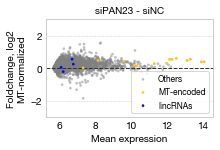

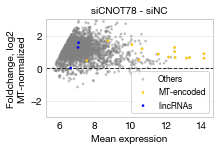

In [33]:
# Normalised by GAPDH readcounts
from scipy.stats import gmean

savefig = False
savetxt = False

marks = ["mtgenes", "lincRNAs"]

scaler = 1000
normed_tagcnt_cutoff = 50

with plt.style.context("deadenylases"):
    for p in pairs:
        fig = plt.figure(figsize=[3,1.8])
        ax = fig.add_subplot(111)
        
        ctrl_tagcnts = df_glstats[["{}:polyA_tag_count".format(p[0]), "{}:nonpolyA_tag_count".format(p[0])]].sum(axis=1).dropna()
        tret_tagcnts = df_glstats[["{}:polyA_tag_count".format(p[1]), "{}:nonpolyA_tag_count".format(p[1])]].sum(axis=1).dropna()
        gapdh = df_glstats[df_glstats["gene_name"] == "GAPDH"].index
        
        
        # Normalisation by GAPDH reads
        ctrl_tagcnts = ctrl_tagcnts / float(ctrl_tagcnts.loc[gapdh]) * scaler
        tret_tagcnts = tret_tagcnts / float(tret_tagcnts.loc[gapdh]) * scaler
        
        # Normalised tag count filter
        ctrl_tagcnts = ctrl_tagcnts[ctrl_tagcnts >= normed_tagcnt_cutoff]
        tret_tagcnts = tret_tagcnts[tret_tagcnts >= normed_tagcnt_cutoff]

        x, y = ctrl_tagcnts.align(tret_tagcnts, join="inner")
#         x, y = ctrl_rpm.align(tret_rpm, join="inner")


        M = np.log2(y) - np.log2(x)
        A = np.log2(x*y) / 2
        
        if savetxt is True:
            outTxtPath = "/casa/joha/projects/deadenylases/pub/texts/mtnormed_abundance_foldchange_{}_{}-{}.csv".format(work, *p)
            tbl = pd.concat([x, y, M], axis=1)
            tbl.columns = ["ctrl", "tret", "log2fc"]
            tbl.index.name = "ensembl_gid"
            tbl.loc[:, "gene_name"] = gid2name.loc[tbl.index]
            tbl.loc[:, ["gene_name", "ctrl", "tret", "log2fc"]].to_csv(outTxtPath)

        ax.scatter(A, M, s=7, color="grey", edgecolor="none", alpha=0.5, rasterized=True, label="Others")
        
        if "mtgenes" in marks:
            ax.scatter(A.loc[mtgenes], M.loc[mtgenes], s=7, color="#FFCB13", edgecolor="none", label="MT-encoded", zorder=7)
        if "lincRNAs" in marks:
            ax.scatter(A.loc[lincRNAs], M.loc[lincRNAs], s=7, color="blue", edgecolor="none", label="lincRNAs", zorder=7)
                
        ax.axhline(y=0, ls="--", lw=1)
        ax.grid(axis="y")
        ax.set_xlabel("Mean expression")
        ax.set_ylabel("Foldchange, log2\nMT-normalized")
        ax.set_title("{} - {}".format(labels[p[1]], labels[p[0]]), fontsize="medium")
        ax.legend(loc="lower right", fontsize="small")
        
#         ax.set_xlim([6, 8])
        ax.set_ylim([-3,3])
        
        if savefig is True:
            outFigPath = "/utp/joha/projects/deadenylases/pub/plots/ma_plot_mt-normed_{}_{}-{}.pdf".format(work, *p)
            plt.savefig(outFigPath, bbox_inches="tight", dpi=300)
            
        plt.show()

/utp/joha/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


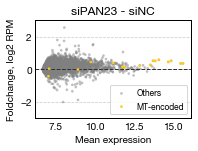

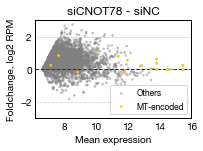

In [70]:

savefig = False

tagcnt_cutoff = 100
rpm_cutoff = 150
with plt.style.context("deadenylases"):
    for p in pairs:
        fig = plt.figure(figsize=[2.8,1.8])
        ax = fig.add_subplot(111)
        
        ctrl_tagcnts = df_glstats[["{}:polyA_tag_count".format(p[0]), "{}:nonpolyA_tag_count".format(p[0])]].sum(axis=1).dropna()
        tret_tagcnts = df_glstats[["{}:polyA_tag_count".format(p[1]), "{}:nonpolyA_tag_count".format(p[1])]].sum(axis=1).dropna()

        # Minimum tag count filter
        ctrl_tagcnts = ctrl_tagcnts[ctrl_tagcnts >= tagcnt_cutoff]
        tret_tagcnts = tret_tagcnts[tret_tagcnts >= tagcnt_cutoff]
        
        # RPM normalisation
#         ctrl_rpm = ctrl_tagcnts.div(ctrl_tagcnts.sum()) * 1000000
#         ctrl_rpm = ctrl_rpm[ctrl_rpm >= rpm_cutoff]
#         tret_rpm = tret_tagcnts.div(tret_tagcnts.sum()) * 1000000
#         tret_rpm = tret_rpm[tret_rpm >= rpm_cutoff]

        x, y = ctrl_tagcnts.align(tret_tagcnts, join="inner")
#         x, y = ctrl_rpm.align(tret_rpm, join="inner")

        M = np.log2(y) - np.log2(x)
        A = np.log2(x*y) / 2

        ax.scatter(A, M, s=7, color="grey", edgecolor="none", alpha=0.5, rasterized=True, label="Others")
        
        ax.scatter(A.loc[mtgenes], M.loc[mtgenes], s=7, color="#FFCB13", edgecolor="none", label="MT-encoded", zorder=7)
                
        ax.axhline(y=0, ls="--", lw=1)
        ax.grid(axis="y")
        ax.set_xlabel("Mean expression")
        ax.set_ylabel("Foldchange, log2 RPM")
        ax.set_title("{} - {}".format(labels[p[1]], labels[p[0]]))
        ax.legend(loc="lower right", fontsize="small")
        
#         ax.set_xlim([6, 8])
        ax.set_ylim([-3,3])
        
        if savefig is True:
            outFigPath = "/utp/joha/projects/deadenylases/pub/plots/ma_plot_{}_{}-{}.pdf".format(work, *p)
            plt.savefig(outFigPath, bbox_inches="tight", dpi=300)
            
        plt.show()

/utp/joha/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


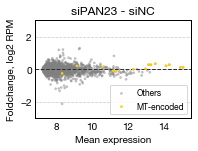

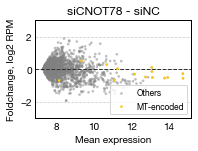

In [67]:
savefig = False

tagcnt_cutoff = 100
rpm_cutoff = 150
with plt.style.context("deadenylases"):
    for p in pairs:
        fig = plt.figure(figsize=[2.8,1.8])
        ax = fig.add_subplot(111)
        
        ctrl_tagcnts = df_glstats[["{}:polyA_tag_count".format(p[0]), "{}:nonpolyA_tag_count".format(p[0])]].sum(axis=1).dropna()
        tret_tagcnts = df_glstats[["{}:polyA_tag_count".format(p[1]), "{}:nonpolyA_tag_count".format(p[1])]].sum(axis=1).dropna()

        # Minimum tag count filter
        ctrl_tagcnts = ctrl_tagcnts[ctrl_tagcnts >= tagcnt_cutoff]
        tret_tagcnts = tret_tagcnts[tret_tagcnts >= tagcnt_cutoff]
        
        # RPM normalisation
        ctrl_rpm = ctrl_tagcnts.div(ctrl_tagcnts.sum()) * 1000000
        ctrl_rpm = ctrl_rpm[ctrl_rpm >= rpm_cutoff]
        tret_rpm = tret_tagcnts.div(tret_tagcnts.sum()) * 1000000
        tret_rpm = tret_rpm[tret_rpm >= rpm_cutoff]

#         x, y = ctrl_tagcnts.align(tret_tagcnts, join="inner")
        x, y = ctrl_rpm.align(tret_rpm, join="inner")

        M = np.log2(y) - np.log2(x)
        A = np.log2(x*y) / 2

        ax.scatter(A, M, s=7, color="grey", edgecolor="none", alpha=0.5, rasterized=True, label="Others")
        
        ax.scatter(A.loc[mtgenes], M.loc[mtgenes], s=7, color="#FFCB13", edgecolor="none", label="MT-encoded", zorder=7)
                
        ax.axhline(y=0, ls="--", lw=1)
        ax.grid(axis="y")
        ax.set_xlabel("Mean expression")
        ax.set_ylabel("Foldchange, log2 RPM")
        ax.set_title("{} - {}".format(labels[p[1]], labels[p[0]]))
        ax.legend(loc="lower right", fontsize="small")
        
#         ax.set_xlim([6, 8])
        ax.set_ylim([-3,3])
        
        if savefig is True:
            outFigPath = "/utp/joha/projects/deadenylases/pub/plots/ma_plot_{}_{}-{}.pdf".format(work, *p)
            plt.savefig(outFigPath, bbox_inches="tight", dpi=300)
            
        plt.show()

In [73]:
ctrl_mtgenes

ENSG00000198804.2    46421.0
ENSG00000198886.2    41745.0
ENSG00000198938.2    25847.0
ENSG00000198712.1    23288.0
ENSG00000198888.2    14670.0
ENSG00000198727.2    12699.0
ENSG00000198840.2    11577.0
ENSG00000210082.2    11260.0
ENSG00000198763.3     7056.0
ENSG00000198899.2     3334.0
ENSG00000211459.2     3766.0
ENSG00000198786.2     2046.0
ENSG00000212907.2      737.0
ENSG00000247627.2      490.0
ENSG00000198695.2      151.0
ENSG00000248527.1      132.0
ENSG00000225630.1       68.0
ENSG00000228253.1       74.0
ENSG00000210100.1       54.0
ENSG00000210112.1       25.0
ENSG00000225972.1       11.0
ENSG00000209082.1       19.0
ENSG00000210196.2       10.0
ENSG00000210077.1        8.0
ENSG00000210191.1        5.0
ENSG00000210144.1        1.0
ENSG00000210117.1        5.0
ENSG00000270906.1        3.0
ENSG00000210176.1        2.0
ENSG00000210184.1        4.0
ENSG00000210194.1        6.0
ENSG00000210107.1        6.0
ENSG00000210195.2        3.0
ENSG00000271480.1        2.0
ENSG0000021004

In [72]:
tret_mtgenes

ENSG00000198804.2    45214.0
ENSG00000198886.2    49532.0
ENSG00000198938.2    26062.0
ENSG00000198712.1    22866.0
ENSG00000198888.2    14778.0
ENSG00000198727.2    16482.0
ENSG00000198840.2    17906.0
ENSG00000210082.2    11572.0
ENSG00000198763.3     8201.0
ENSG00000198899.2     4866.0
ENSG00000211459.2     3389.0
ENSG00000198786.2     3569.0
ENSG00000212907.2     1511.0
ENSG00000247627.2      435.0
ENSG00000198695.2      273.0
ENSG00000248527.1      157.0
ENSG00000225630.1      183.0
ENSG00000228253.1       86.0
ENSG00000210100.1       74.0
ENSG00000210112.1       23.0
ENSG00000225972.1        7.0
ENSG00000209082.1       11.0
ENSG00000210196.2       17.0
ENSG00000210077.1        9.0
ENSG00000210191.1       14.0
ENSG00000210144.1       17.0
ENSG00000210117.1        8.0
ENSG00000270906.1        2.0
ENSG00000210176.1        9.0
ENSG00000210184.1        6.0
ENSG00000210194.1        6.0
ENSG00000210107.1        2.0
ENSG00000210195.2        3.0
ENSG00000271480.1        2.0
ENSG0000021004

In [68]:
(M > 0.2).sum()

436

In [69]:
(M < -0.2 ).sum()

452